<a href="https://colab.research.google.com/github/aniruddhapal/NLP-Named-Entity-Recognition-/blob/main/Named_Entity_Recognition_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn')

In [ ]:
#Mount the G Drive to access the data set
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/My Drive/Colab Notebooks')



In [ ]:
data=pd.read_csv('ner_dataset.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
#Delete the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [ ]:
data.head(15)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
5,NaN,through,O
6,NaN,London,B-geo
7,NaN,to,O
8,NaN,protest,O
9,NaN,the,O


In [ ]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

In [ ]:
data.head(35)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [ ]:
words=list(set(data['Word'].values))
words.append("ENDPAD")
words[-1]

'ENDPAD'

In [ ]:
#Total no. of words
print("Total number of words",num_words)

Total number of words 35179


In [ ]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
num_tags
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-art, I-tim, B-eve, B-art, I-eve, B-org, I-per, I-geo, B-gpe, I-nat, B-geo, O, B-tim, I-org, B-per, B-nat, I-gpe
Total Number of tags 17


In [ ]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [ ]:
#Creating a class which will give the complete sentence with Tags attached with each word
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    self.sentences=[s for s in self.grouped]

In [ ]:
getter=Get_sentence(data)
sentence=getter.sentences

In [ ]:
sentence[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [ ]:
### Data Visualizaion

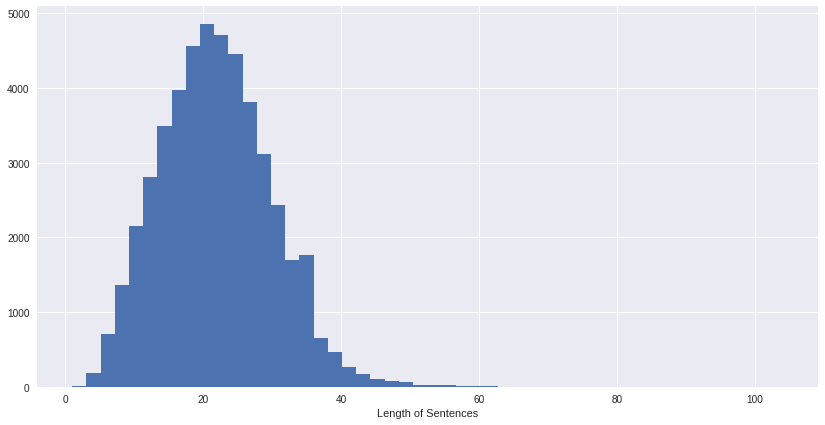

In [ ]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

In [ ]:
# most of our sentenses have a length of 20 words, the longest sentense is around 63 words



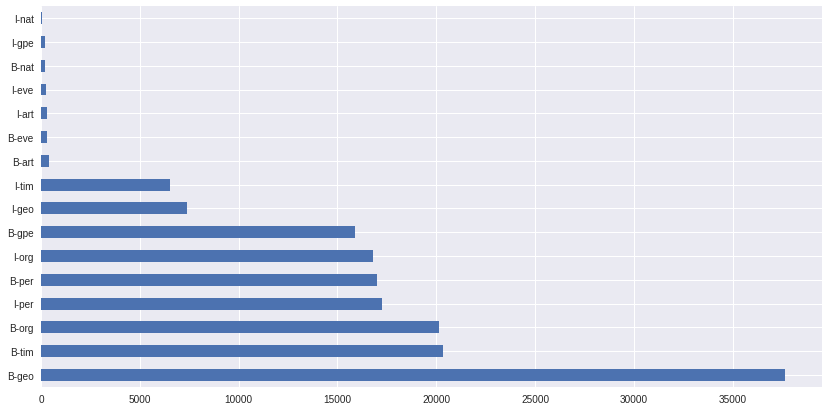

In [ ]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

In [ ]:
## We can understand from the bar chart above that B-geo Tags are over-represented. 
## I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

In [148]:
# Data Preparation

In [ ]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [ ]:
word_idx['Dniester']

8221

In [ ]:
# Padding our sentences using max lenght of 50.
max_len=50
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])


In [ ]:
X[0]

array([30952, 14951,  8890,  3741,  3408, 33336, 29271, 31741, 13655,
       14974, 10072, 14689, 32720, 10162, 22415, 14974, 21925, 14951,
        2857,    64, 14517,  9973,  8060, 26948, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [ ]:
y[0]

array([11, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 10, 11, 11, 11, 11,
       11,  8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype=int32)

In [ ]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [ ]:
num_tags

17

In [ ]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [82]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

In [ ]:
# Building the model

In [ ]:
input_word=Input(shape=(max_len,))
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model=Model(input_word,out)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


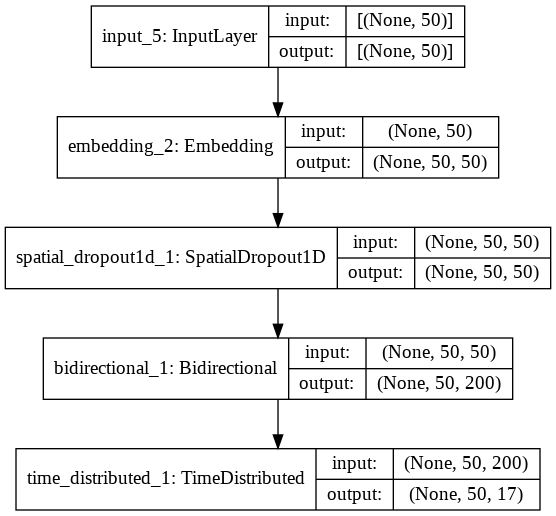

In [ ]:
plot_model(model,show_shapes=True)

In [84]:
#Training the model with Training data
model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

Epoch 1/3
540/540 [==============================] - 140s 251ms/step - loss: 0.2642 - accuracy: 0.9461 - val_loss: 0.1009 - val_accuracy: 0.9723
Epoch 2/3
540/540 [==============================] - 135s 250ms/step - loss: 0.0700 - accuracy: 0.9804 - val_loss: 0.0587 - val_accuracy: 0.9825
Epoch 3/3
540/540 [==============================] - 134s 249ms/step - loss: 0.0459 - accuracy: 0.9865 - val_loss: 0.0518 - val_accuracy: 0.9846


In [ ]:
# Model Evaluation

In [85]:
model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 4s 27ms/step - loss: 0.0542 - accuracy: 0.9840


[0.05419158190488815, 0.9839908480644226]

In [136]:
# Model Prediction with Test set
rand_sent=np.random.randint(0,X_test.shape[0])
p=model.predict(np.array([X_test[rand_sent]]))
p=np.argmax(p,axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
  print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

Word                True                	Pred

-------------------------------------------------------
The                 O                   	O
decision            O                   	O
comes               O                   	O
after               O                   	O
China               B-geo               	B-geo
and                 O                   	O
Argentina           B-geo               	B-geo
signed              O                   	O
accords             O                   	O
that                O                   	O
could               O                   	O
bring               O                   	O
more                O                   	O
than                O                   	O
$                   O                   	O
20                  O                   	O
billion             O                   	O
in                  O                   	O
Chinese             B-gpe               	B-gpe
investment          O                   	O
to                  O    